In [81]:
%matplotlib inline
import networkx as nx
import math
import random
from collections import defaultdict

In [51]:


# dataset
X = [[0, 0],
     [0, 1],
     [1, 0], 
     [1, 1]]
y = [0, 1, 1, 0]

class Node:

    def __init__(self, name, activator, G):
        self.name = name
        self.activator = activator
        self.weights = None
        self.value = 0
        self.gradients = []
        self.grad = 0
        pass

    def forward(self, parents):
        if self.weights is None:
            self.weights = [random.random() for _ in range(len(parents))]
            self.gradients = [0 for _ in range(len(parents))]
        
        before_activation = sum([self.weights[i] * parents[i].value 
                                 for i in range(len(parents))])
        self.value = self.activator(before_activation)
    
    def backward(self, parents):
        print("Backward", self.name, "with", parents)
        # Sum over the grad for the 
        sum_of_incoming_grad = sum([parent.grad for parent in parents])
        for i in range(len(self.weights)):
            self.gradients[i] = sum_of_incoming_grad * self.activator.gradient(self.weights[i])

        print("Computed", self.gradients)
        self.grad = sum(self.gradients)
        
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return "{}={}".format(self.name, self.value)
    
    def __hash__(self):
        return hash(self.name)
    
    def __eq__(self, other):
        return self.name == other.name

class Activation:
    
    pass

class Sigmoid(Activation):
    def __call__(self, values):
        return 1 / (1 + math.exp(-sum(values)))
                
    
    def gradient(self, weight):
        return self(weight) * (1 - self(weight))
    

class Identity(Activation):
    def __call__(self, values):
        return values
    
    def gradient(self, weight):
        return 1.0

Create the architecture

In [79]:
G = nx.DiGraph()

# Input nodes
d_input = len(X[0])

input_nodes = []
for i in range(d_input):
    input_node = "x" + str(i)
    input_nodes.append(input_node)
    G.add_node(input_node, activator=Identity())

# Intermediate layer
for i in range(3):
    hidden_node = "h" + str(i)
    G.add_node(hidden_node, activator=Sigmoid())
    for input_node in input_nodes:
        G.add_edge(input_node, hidden_node, w=random.random()*0.01)

# Final layer
output_node = "y"
G.add_node(output_node, activator=Sigmoid())
for n in G.nodes():
    if n.startswith("h"):
        G.add_edge(n, output_node, w=0)

In [102]:
weights = defaultdict(lambda: random.random() * 0.01)
gradients = {}


The backward pass calculates the gradients of each weights with respect to the total function that the neural network represents.

This can be thought of as finding, for each weight, a linear approximation of the NN function, while keeping all of the other parameters fixed. Let $NN(\mathbf{x}, \mathbf{W})$ be function computed by the neural network, $w$ a specific weight in the network, $m = \frac{\partial NN}{\partial w}$

$$g(w) = NN(\mathbf{x}, \mathbf{W}) + m(w - a)$$

In [ ]:
gradients = defaultdict(lambda: np.zeros(1))




def backward(v):
    # We're filling in all the gradients associated with a node in the 
    # neural network. These are 
    # - gradients for each of the weights on the incoming edges.
    # - how much influence this node has on the NN function.
    
    
    parents = G[v].edges()
    
    # Current node influence (sum of gradients )
    node_influence = sum([G.node[parent].get('grad', 0) for parent in parents])
    
    
    # Update gradients for weights
    
    
    
    
    G.predecessors(v)

In [89]:

def forward(v):
    inputs = [G.node[u]['value'] * weights[(u, v)] 
              for u in G.predecessors(v)]
    if inputs:
        v_attr = G.node[v]
        activation = v_attr['activator'](inputs)
        v_attr['value'] = activation
        


for x in X:
    # Initialize values of the input nodes and do the forward computation
    for i, input_node in enumerate(input_nodes):
        G.node[input_node]['value'] = x[i]
        
    for n in nx.topological_sort(G):
        forward(n)
            
    print(G.node['y'])

    # Backward pass
    for n in nx.topological_sort(G, reverse=True):
        if not n.startswith("x"):
            G[n].keys()
        
        #if n not in input_nodes:
            #preds = G_rev.predecessors(n)
            #print(type(preds), preds)
            #n.backward(preds)

            
    
    
    
    



{'value': 0.5012460516246513, 'activator': <__main__.Sigmoid object at 0x108d770f0>}
Is tree False
{'value': 0.5012503477195154, 'activator': <__main__.Sigmoid object at 0x108d770f0>}
Is tree False
{'value': 0.5012489865922255, 'activator': <__main__.Sigmoid object at 0x108d770f0>}
Is tree False
{'value': 0.5012532826200476, 'activator': <__main__.Sigmoid object at 0x108d770f0>}
Is tree False


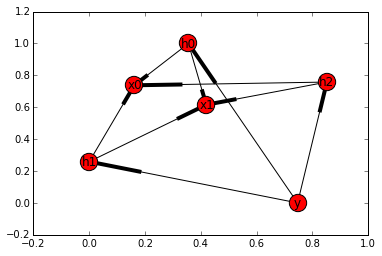

In [ ]:
import random

In [78]:
[(u, G.node[u]) for u, _, edge in G.in_edges('h1', data=True)]

[('x0', {'activator': <__main__.Identity at 0x108fccac8>}),
 ('x1', {'activator': <__main__.Identity at 0x108fccbe0>})]

In [100]:
G['x1'].keys()

dict_keys(['h1', 'h2', 'h0'])

In [94]:
nx.topological_sort(G, reverse=True)

['y', 'h0', 'h2', 'h1', 'x0', 'x1']

In [101]:
G.predecessors('x0')

[]